## One Cluster Test with GCR

This will be compiling Cartesian data for any one cluster I choose using GCRCatalogs. I can then compare results to those using dask arrays

In [1]:
# math, array manipulation, etc.
import numpy as np
import esutil                    # must use desc-stack kernel

# get central galaxy/BCG and cluster member data
import GCRCatalogs as gcr

# astropy
import astropy.io.fits as fits                     # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM        # making cosmological calculations
from astropy import units as u                     # units
from astropy.table import Table                    # Table data structure

# for timing loops 
from tqdm import *
import time

# plots
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

# opening and extracting data from HDF5 files
import os
import h5py

# dask data structures, pandas operations, etc.
import dask as da
import dask.dataframe as dd

### Compile Cluster Data

In [2]:
# redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [3]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)

# these are the quantities that describe each cluster's member galaxies
mem_quantities = [q for q in redM_quantities if 'member' in q]
print("\nMember quantities:\n")
print(mem_quantities)

All redMaPPer quantities:

['magerr_g_lsst_member', 'mag_i_lsst_member', 'ra_cen_3', 'p_cen_4', 'dec', 'p_cen_0', 'theta_r_member', 'redshift_true_cg', 'mag_g_lsst_member', 'id_cen_0', 'p_cen_1', 'mag_y_lsst_member', 'refmag_err_member', 'dec_cen_2', 'cluster_id', 'id_member', 'ra_member', 'mag_r_lsst_member', 'redshift_err', 'mag_z_lsst_member', 'redshift_true_member', 'pfree_member', 'dec_member', 'theta_i_member', 'magerr_r_lsst_member', 'magerr_z_lsst_member', 'dec_cen_0', 'magerr_i_lsst_member', 'refmag_member', 'ra', 'dec_cen_1', 'redshift', 'dec_cen_4', 'p_cen_3', 'id_cen_3', 'magerr_y_lsst_member', 'p_cen_2', 'ra_cen_0', 'id_cen_2', 'id_cen_1', 'dec_cen_3', 'richness', 'ra_cen_2', 'richness_err', 'p_member', 'scaleval', 'maskfrac', 'id_cen_4', 'ra_cen_4', 'cluster_id_member', 'ra_cen_1']

Cluster quantities:

['ra_cen_3', 'p_cen_4', 'dec', 'p_cen_0', 'redshift_true_cg', 'id_cen_0', 'p_cen_1', 'dec_cen_2', 'cluster_id', 'redshift_err', 'dec_cen_0', 'ra', 'dec_cen_1', 'redshift',

In [4]:
# get cluster data
redM_data = Table(redM_gcr.get_quantities(cluster_quantities))

# get member data
mem_data = Table(redM_gcr.get_quantities(mem_quantities))

In [5]:
# filter out duplicate members
uniq_mem_ids, uniq_mem_ind = np.unique(mem_data['id_member'], return_index=True)
filtered_mem_data = mem_data[uniq_mem_ind]
print ("There are {} unique members in the dataset.".format(len(filtered_mem_data)))

There are 209096 unique members in the dataset.


In [6]:
# extract member galaxy IDs
mem_ids = filtered_mem_data['id_member']

In [7]:
# extract cluster IDs
clusters = np.unique(redM_data['cluster_id'])

In [197]:
# extract member data for one cluster
cluster_ind = 0
cluster_id = clusters[cluster_ind]
one_cluster = filtered_mem_data[np.where(filtered_mem_data['cluster_id_member'] == cluster_id)]
min_id = np.min(one_cluster['id_member'])
max_id = np.max(one_cluster['id_member'])
print(min_id)
print(max_id)

4000531618
4001943549


### Estimate Cluster Radius as Function of Richness

From [Rykoff, *et al*. (2014)](https://arxiv.org/pdf/1303.3562.pdf), we have the following equation:

$R_{\rm c}(\lambda) = 1$ $\rm Mpc$ $\rm h^{-1}$ $(\frac{\lambda}  {100})^{0.2}$

We can use this to estimate cluster radius. This may be important later.

Also, note that for an equation in the form $\rm f = \rm a \rm A^{\rm b}$, where $\rm A$ is a variable and $\rm a$ and $\rm b$ are constants, we use the following for error propagation:

$\sigma_{\rm f} = \frac{\rm f \rm b \sigma_{\rm a}}{\rm A}$

So, let's add both `R_c` and `R_c_err` statistics.

In [198]:
redM_data['R_c'] = (redM_data['richness'] / 100) ** 0.2
redM_data['R_c_err'] = (redM_data['R_c'] 
                             * 0.2 
                             * redM_data['richness_err']) / redM_data['richness']

### Define Cosmology

This should be according to parameters outlined [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

In [199]:
# define the cosmology
cosmo = redM_gcr.cosmology
cosmo

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

### Compile Data for the One Cluster

In [10]:
# call cosmoDC2 catalog
cosmoDC2_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_image')

In [200]:
# define wanted quantities and filters
quantities_wanted = ['galaxy_id'
                     , 'position_x'
                     , 'position_y'
                     , 'position_z'
                     , 'redshift']

query = ['galaxy_id >= {}'.format(min_id), 'galaxy_id <= {}'.format(max_id)]

In [201]:
# read data in from catalog
galaxy_data = Table(cosmoDC2_gcr.get_quantities(quantities_wanted
                                                , filters=query))

In [202]:
# find matching indices between one_cluster and galaxy_data
gal_ind, mem_ind = esutil.numpy_util.match(galaxy_data['galaxy_id'], one_cluster['id_member'])

In [203]:
for i, ind in enumerate(mem_ind):
    assert i == ind

In [204]:
# identify BCG
cluster = redM_data[np.where(redM_data['cluster_id'] == cluster_id)]
bcg_id = cluster['id_cen_0']
bcg_id

4001164411


In [205]:
# get estimated cluster radius
R_c = cluster['R_c']

In [206]:
# filter galaxy_data for the cluster member IDs
filt_gal_data = galaxy_data[gal_ind][quantities_wanted]

# add ra and dec values
filt_gal_data['ra'] = one_cluster['ra_member']
filt_gal_data['dec'] = one_cluster['dec_member']

# extract comoving distance
gal_comvd = cosmo.comoving_distance(filt_gal_data['redshift']).value

# extract BCG data
bcg_ind = np.where(filt_gal_data['galaxy_id'] == bcg_id)
bcg_data = filt_gal_data[bcg_ind]

In [207]:
filt_gal_data

galaxy_id,position_x,position_y,position_z,redshift,ra,dec
int64,float64,float64,float64,float64,float64,float64
4000531618,1154.9172038763343,1384.7105214293574,-1089.5523339929716,0.5690668404244217,50.17814085973227,-31.145342797385947
4000751615,1269.8791718818773,1522.1655509841275,-1196.3280906139964,0.6342937514804166,50.17034297118035,-31.114668853493406
4000855416,1370.0237435354313,1636.5471638424297,-1289.7585586762764,0.6919024983552968,50.07344261516842,-31.148916314723223
4000914401,1340.3831804302376,1607.198194047095,-1267.3639861630722,0.678271310237921,50.17979788771395,-31.203223343976596
4000985118,1434.5924914722711,1714.0643912301937,-1352.650301221391,0.7332167531267111,50.0802766563703,-31.18611735140271
4000992891,1433.1377915933099,1716.028347821303,-1354.9544213523327,0.7332437875142535,50.141298224156955,-31.223030493731617
4000999493,1431.9870639854755,1712.970916318222,-1349.447244993398,0.7308649027739453,50.11357957420053,-31.154491264230565
4001000215,1433.4526814205547,1716.5374326034332,-1353.4866547920335,0.7333204862871059,50.14339408418509,-31.188408453356356
4001001262,1433.8658077616087,1714.9915668326366,-1352.2662955270687,0.7321864932830335,50.10986723212213,-31.175956170038692


In [208]:
# let's calculate the comoving distance of each member galaxy to the BCG

# use Pythagorean theorem
delta_x = bcg_data['position_x'] - filt_gal_data['position_x']
delta_y = bcg_data['position_y'] - filt_gal_data['position_y']
delta_z = bcg_data['position_z'] - filt_gal_data['position_z']

dist_cmv = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)

### Plots

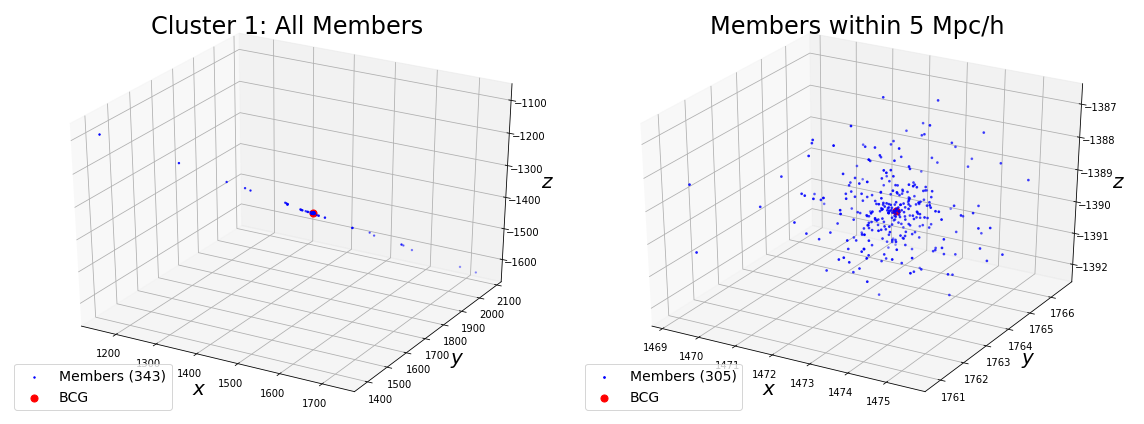

Coordinates are in units of Mpc/h.


In [221]:
# 3D plots

dcmv_lim = 5
dcmv_ind = np.where(dist_cmv <= dcmv_lim)

filt_gal_data_lim = filt_gal_data[dcmv_ind]

# get coordinates

x = filt_gal_data['position_x']
y = filt_gal_data['position_y']
z = filt_gal_data['position_z']

x_lim = filt_gal_data_lim['position_x']
y_lim = filt_gal_data_lim['position_y']
z_lim = filt_gal_data_lim['position_z']

bcg_x = bcg_data['position_x']
bcg_y = bcg_data['position_y']
bcg_z = bcg_data['position_z']

fig = plt.figure(figsize=(16,6))

#plt.title('Cluster ID: {}'.format(clusters[cluster_ind]), fontsize=18)

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(x, y, z, s=2, c='b', label='Members ({})'.format(len(filt_gal_data)))
ax2.scatter(x_lim, y_lim, z_lim, s=3, c='b', label='Members ({})'.format(len(filt_gal_data_lim)))

ax1.scatter(bcg_x, bcg_y, bcg_z, s=50, c='r', label='BCG')
ax2.scatter(bcg_x, bcg_y, bcg_z, s=50, c='r', label='BCG')

ax1.set_title('Cluster {}: All Members'.format(cluster_id), fontsize=24)
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_zlabel(r'$z$', fontsize=20)

if dcmv_lim % R_c == 0.0:
    ax2.set_title('Members within %.5f Mpc/h' % dcmv_lim, fontsize=24)
else:
    ax2.set_title(r'Members within {} Mpc/h'.format(dcmv_lim), fontsize=24)

ax2.set_xlabel(r'$x$', fontsize=20)
ax2.set_ylabel(r'$y$', fontsize=20)
ax2.set_zlabel(r'$z$', fontsize=20)

L1 = ax1.legend(loc=3, prop={'size':14})
L2 = ax2.legend(loc=3, prop={'size':14})

plt.tight_layout()
plt.show()

print('Coordinates are in units of Mpc/h.')

There is clearly a problem here. I'm still not certain as to its nature or whether or not it has to do with my code, but I got these exact same Cartesian coordinates for this cluster using data from HDF5 files. Both of my methods seemed to give the same results, and it seems as though some of the members are actually that far away from the BCG. At least, that is my impression.

The Cartesian coordinates were extracted by loading in the data from GCR and then filtering for galaxy IDs also found in the member data for this cluster. 

What may be encouraging is that there do not seem to be many members that are very far away. I've included a distribution below.

The mean comoving distance to the BCG is 15.640643702431406
The median comoving distance to the BCG is 1.3470227422157703
The standard deviation of dist_cmv is 62.2872285869067


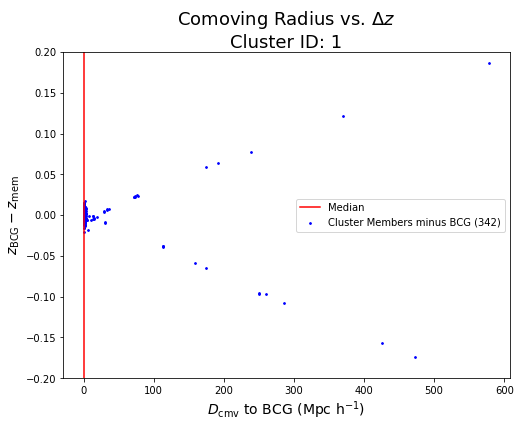

In [214]:
# get change in redshift from BCG redshift
delta_redshift = bcg_data['redshift'] - filt_gal_data['redshift']

# get some distribution statistics
dcmv_mean = np.mean(dist_cmv)
dcmv_med = np.median(dist_cmv)
dcmv_stdev = np.std(dist_cmv)

# create linear space for plotting the mean, median, and several stdev distances
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + dcmv_mean
x_med = 0*y + dcmv_med
x_1sigma = 0*y + dcmv_stdev
x_2sigma = 0*y + 2*dcmv_stdev
x_3sigma = 0*y + 3*dcmv_stdev

print("The mean comoving distance to the BCG is", dcmv_mean)
print("The median comoving distance to the BCG is", dcmv_med)
print("The standard deviation of dist_cmv is", dcmv_stdev)

# with E_gcr - E_calculated as colorbar

plt.figure(figsize=(8,6))
plt.scatter(dist_cmv
            , delta_redshift
            , c='b'
            #, cmap='viridis'
            , s=3
            , label = 'Cluster Members minus BCG ({})'.format(len(filt_gal_data) - 1))

plt.plot(x_med, y, 'r', label=r'Median')

'''
plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med + x_1sigma, y, 'c', label=r'$\pm 1,2,3$ Standard Deviations')
plt.plot(x_med - x_1sigma, y, 'c')
plt.plot(x_med + x_2sigma, y, 'c')
plt.plot(x_med - x_2sigma, y, 'c')
plt.plot(x_med + x_3sigma, y, 'c')
plt.plot(x_med - x_3sigma, y, 'c')'''

plt.legend(loc='best')
plt.xlabel(r'$D_{\rm cmv}$ to BCG ($\rm Mpc$ $\rm h^{-1}$)', fontsize=14)
plt.ylabel(r'$z_{\rm BCG} - z_{\rm mem}$', fontsize=14)
#plt.xlim(-.1, .1)
plt.ylim(-.2, .2)

plt.title(r'''Comoving Radius vs. $\Delta z$
Cluster ID: {}'''.format(cluster_id), fontsize=18)
plt.show()

Of course, this curve makes tons of sense, since we'd expect higher $|\Delta z|$ values to correlate with larger comoving radius. But even though we do have some higher $R_{\rm cmv}$ values, most of them are very small, with over 300 out of 343 cluster members being within $5$ $\rm Mpc$ $\rm h^{-1}$ of the BCG.

Let's plot a histogram showing the distribution of this cluster's $R_{\rm cmv}$ values. I'm repeating this process for this cluster in the other notebook, where I extract coordinates for all member galaixes.

The median comoving radius for cluster ID 1 is 1.3470227422157703.


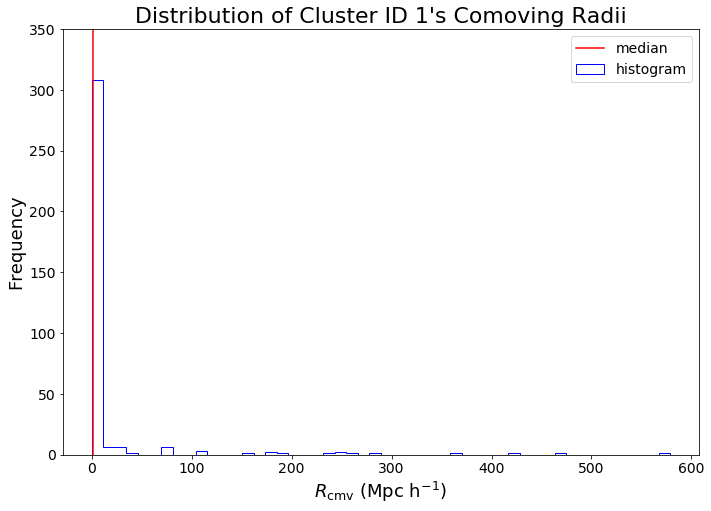

In [215]:
# extract median
dcmv_med = np.median(dist_cmv)

print("The median comoving radius for cluster ID {} is {}.".format(cluster_id, dcmv_med))

# get vertical lines at these values
y = np.linspace(-1, 1e5, 5)
x = 0*y + dcmv_med

fig, ax = plt.subplots(1,1)
fig.set_figheight(7.2)
fig.set_figwidth(10)

# histogram
ax.hist(dist_cmv, bins=50, color='b', histtype=u'step', label='histogram')

# lines
ax.plot(x, y, c='red', label='median') 

# title and axes
ax.set_title("Distribution of Cluster ID {}'s Comoving Radii".format(cluster_id), fontsize=22)
ax.set_xlabel(r'$R_{\rm cmv}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=18)
ax.set_ylabel(r'Frequency', fontsize=18)

ax.set_xticks(np.linspace(0, 600, 7))
ax.set_xticklabels(np.linspace(0, 600, 7).astype(int).astype(str), fontsize=14)

ax.set_yticks(np.linspace(0, 350, 8))
ax.set_yticklabels(np.linspace(0, 350, 8).astype(int).astype(str), fontsize=14)

ax.legend(loc='upper right', fontsize=14)
ax.set_ylim(1e-2,3.5e2)

plt.tight_layout()
plt.show()

The two graphs are identical to one another. For this cluster, at least, extracting data from HDF5 files worked properly. I had more confidence that the correct data for this one cluster was extracted using GCR than H5py, but there appears to have been no difference between the two methods. So, since H5py is far less costly, I believe we should use it.

I think this also may give some evidence that the redMaPPer member data has assigned some galaxies to clusters that are ridiculously far away. I'm unfamiliar with a lot of details regarding the redMaPPer pipeline, but I wonder if it assigns members to clusters primarily based on angular separation as opposed to other quantities like lensed redshift. We can see below that the cluster's members all lie within the same tiny region of sky.

In [216]:
# for colorbar utilities
import matplotlib.colors as colors

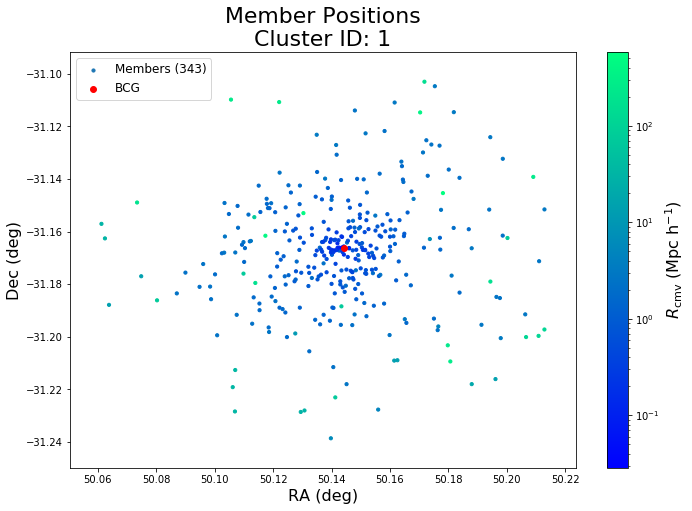

In [217]:
# scatter plot of the cluster and its members in the sky

plt.figure(figsize=(10,7.2))
plt.scatter(filt_gal_data['ra']
            , filt_gal_data['dec']
            , c=dist_cmv
            , cmap='winter'
            , s=10
            , label='Members ({})'.format(len(filt_gal_data))
            , norm=colors.LogNorm()
           )

plt.xlabel('RA (deg)', fontsize=16)
plt.ylabel('Dec (deg)', fontsize=16)

plt.title('Member Positions\nCluster ID: {}'.format(cluster_id), fontsize=22)
plt.tight_layout()

plt.colorbar().set_label(r'$R_{\rm cmv}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=16)

plt.scatter(bcg_data['ra'], bcg_data['dec'], c='r', s=35, label='BCG')
plt.legend(fontsize=12, loc='upper left')

plt.show()

Of course, most of those with the smallest angular separations to the BCG also have some of the smallest $R_{\rm cmv}$ values. However,  some of the members that are located much further away in comoving Cartesian space are still located fairly close in terms of angular separation.

Generally, however, it seems as though there is a positive correlation between angular separation and comoving radius. Let's look at that.

In [218]:
# coordinate systems
from astropy.coordinates import SkyCoord

In [219]:
# extract member and BCG equatorial coordinates
mem_ra = filt_gal_data['ra']; mem_dec = filt_gal_data['dec']
bcg_ra = bcg_data['ra']; bcg_dec = bcg_data['dec']

# coordinate system
mem_coord = SkyCoord(mem_ra*u.deg, mem_dec*u.deg, frame='icrs')
bcg_coord = SkyCoord(bcg_ra*u.deg, bcg_dec*u.deg, frame='icrs')

# calculate angular separation
ang_sep = mem_coord.separation(bcg_coord)

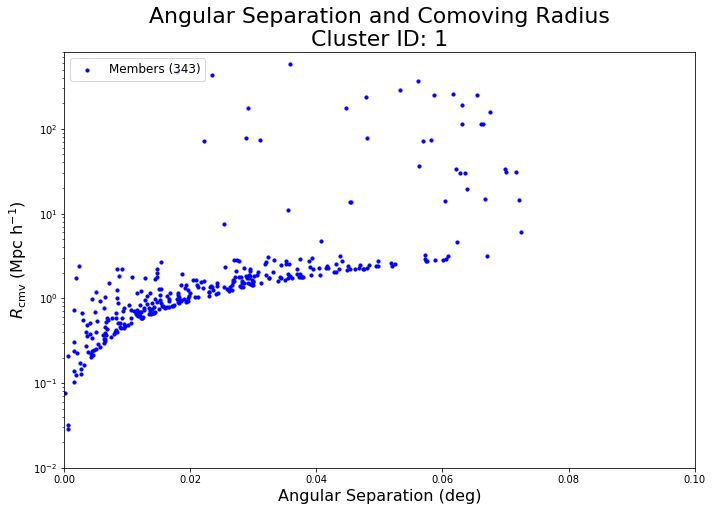

In [220]:
# graph

plt.figure(figsize=(10,7.2))
plt.scatter(ang_sep
            , dist_cmv
            , c='b'
            , s=10
            , label='Members ({})'.format(len(filt_gal_data))
           )

plt.xlabel('Angular Separation (deg)', fontsize=16)
plt.ylabel(r'$R_{\rm cmv}$ ($\rm Mpc$ $\rm h^{-1}$)', fontsize=16)
plt.yscale('log')
plt.xlim(0, 0.1)
plt.ylim(1e-2, 8e2)

plt.title('Angular Separation and Comoving Radius\nCluster ID: {}'.format(cluster_id), fontsize=22)
plt.tight_layout()

plt.legend(fontsize=12, loc='upper left')

plt.show()

Although with a small slope, there does seem to be a direct positive relation between these two statistics, or at least that is the case for this cluster. There seems to be a curve outlined by this trend such that all data points lie above the curve. We can look at more clusters at some point.